<a href="https://colab.research.google.com/github/chef-itachi/Break-Occer/blob/master/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'emotion-dataset' dataset.


/tmp/ipython-input-1874541254.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.sample(max_count, replace=True, random_state=42)).reset_index(drop=True)


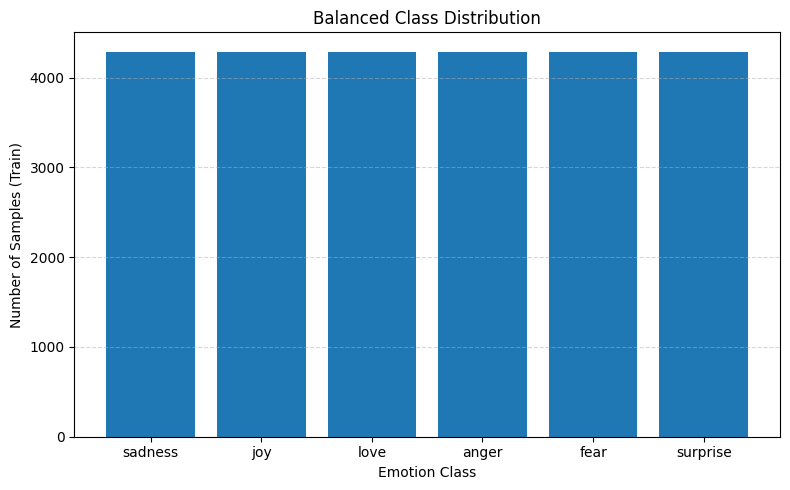

Accuracy: 0.8514374514374514
              precision    recall  f1-score   support

     sadness       0.81      0.78      0.79      1072
         joy       0.76      0.76      0.76      1072
        love       0.89      0.94      0.91      1073
       anger       0.87      0.85      0.86      1073
        fear       0.90      0.81      0.85      1073
    surprise       0.89      0.97      0.93      1072

    accuracy                           0.85      6435
   macro avg       0.85      0.85      0.85      6435
weighted avg       0.85      0.85      0.85      6435



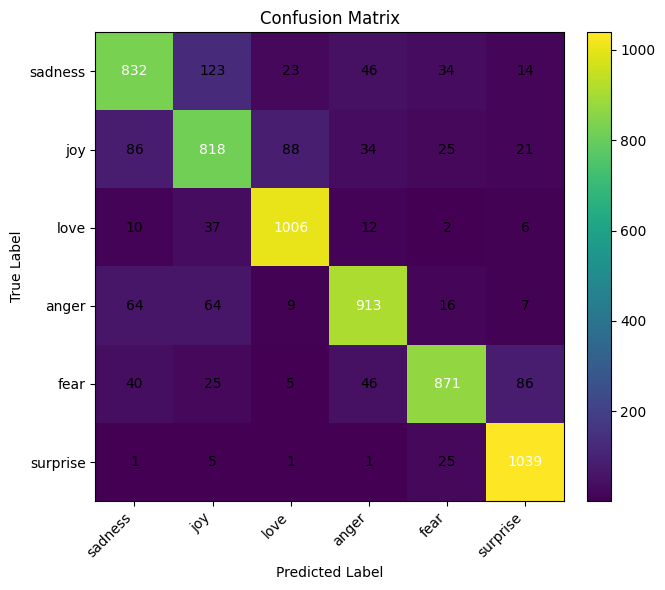

Enter text to analyze sentiment: i love you
Predicted emotion: love
Class Probabilities (sorted):
love       : 0.2009
fear       : 0.1708
anger      : 0.1645
sadness    : 0.1574
joy        : 0.1537
surprise   : 0.1528


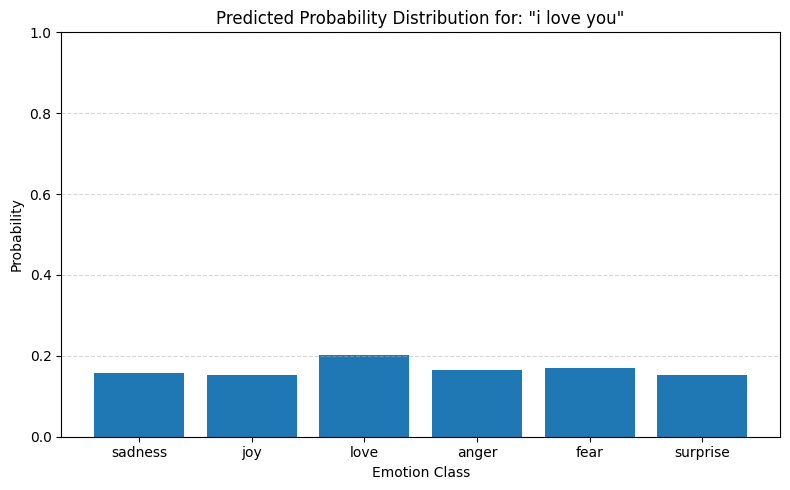

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import check_random_state
from sklearn.cluster import KMeans

import kagglehub

path = kagglehub.dataset_download("parulpandey/emotion-dataset")
csv_path = os.path.join(path, "training.csv")

df = pd.read_csv(csv_path)
df = df.dropna(subset=["text", "label"])

canonical = ["sadness", "joy", "love", "anger", "fear", "surprise"]

if not np.issubdtype(df["label"].dtype, np.number):
    mapping = {name: i for i, name in enumerate(canonical)}
    df = df[df["label"].isin(mapping)]
    df["label"] = df["label"].map(mapping)

max_count = df["label"].value_counts().max()
df = df.groupby("label").apply(lambda x: x.sample(max_count, replace=True, random_state=42)).reset_index(drop=True)

labels = sorted(df["label"].unique())
n_classes = len(labels)
reverse_map = {lbl: canonical[lbl] for lbl in labels}

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

train_counts = y_train.value_counts().sort_index()
train_labels = [reverse_map[i] for i in train_counts.index]

plt.figure(figsize=(8, 5))
plt.bar(train_labels, train_counts.values)
plt.xlabel("Emotion Class")
plt.ylabel("Number of Samples (Train)")
plt.title("Balanced Class Distribution")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

vectorizer = TfidfVectorizer(max_features=12000, stop_words="english", lowercase=True)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

svd = TruncatedSVD(n_components=500, random_state=42)
X_train_low = svd.fit_transform(X_train_tfidf)
X_test_low = svd.transform(X_test_tfidf)

rng = check_random_state(42)
centers_per_class = 80
centers_list = []

for cls in labels:
    idx = np.where(y_train.values == cls)[0]
    Xc = X_train_low[idx]
    k = min(centers_per_class, len(Xc))
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(Xc)
    centers_list.append(kmeans.cluster_centers_)

centers = np.vstack(centers_list)
num_centers = centers.shape[0]

def euclid(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

dists = np.zeros((num_centers, num_centers))
for i in range(num_centers):
    dists[i] = euclid(centers, centers[i])

nearest_k = 20
sigmas = np.zeros(num_centers)

for i in range(num_centers):
    sorted_dist = np.sort(dists[i])[1:nearest_k + 1]
    sigmas[i] = max(1e-3, np.mean(sorted_dist)) if sorted_dist.size > 0 else 1.0

sigmas += 1e-8

def rbf_phi(X, centers, sigmas):
    n = X.shape[0]
    c = centers.shape[0]
    Phi = np.empty((n, c))
    for j in range(c):
        diff = X - centers[j]
        sq = np.sum(diff * diff, axis=1)
        Phi[:, j] = np.exp(-sq / (2.0 * (sigmas[j] ** 2)))
    return Phi

Phi_train = rbf_phi(X_train_low, centers, sigmas)
Phi_test = rbf_phi(X_test_low, centers, sigmas)

try:
    enc = OneHotEncoder(sparse_output=False)
except:
    enc = OneHotEncoder(sparse=False)

Y_train_onehot = enc.fit_transform(y_train.values.reshape(-1, 1))

lambda_reg = 1e-3
A = Phi_train.T.dot(Phi_train) + lambda_reg * np.eye(num_centers)
W = np.linalg.solve(A, Phi_train.T.dot(Y_train_onehot))

def softmax_rowwise(Z):
    Z = Z - np.max(Z, axis=1, keepdims=True)
    expZ = np.exp(Z)
    return expZ / (np.sum(expZ, axis=1, keepdims=True) + 1e-12)

scores_test = Phi_test.dot(W)
probs_test = softmax_rowwise(scores_test)
y_pred = np.argmax(probs_test, axis=1)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

target_names = [reverse_map[i] for i in range(n_classes)]
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 6))
im = plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar(im, fraction=0.046, pad=0.04)
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, target_names, rotation=45, ha="right")
plt.yticks(tick_marks, target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

def predict_text(text):
    v = vectorizer.transform([text])
    low = svd.transform(v)
    phi = rbf_phi(low, centers, sigmas)
    s = phi.dot(W)
    p = softmax_rowwise(s.reshape(1, -1)).ravel()
    idx = int(np.argmax(p))
    return canonical[idx], p

u = input("Enter text to analyze sentiment: ")
lab, p = predict_text(u)
print("Predicted emotion:", lab)

sorted_probs = sorted(list(zip(canonical, p.tolist())), key=lambda x: x[1], reverse=True)
print("Class Probabilities (sorted):")
for cls, prob in sorted_probs:
    print(f"{cls:10} : {prob:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(canonical, p)
plt.xlabel("Emotion Class")
plt.ylabel("Probability")
plt.title(f"Predicted Probability Distribution for: \"{u[:40]}{'...' if len(u) > 40 else ''}\"")
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
